In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

In [ ]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [ ]:
X_train = X_train.reshape(X_train.shape[0],1,28*28)
X_train = X_train.astype(np.float64)
X_train /= 255
X_train = X_train.squeeze()
X_test = X_test.reshape(X_test.shape[0],1,28*28)
X_test = X_test.astype(np.float64).squeeze()
X_test /= 255

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
class Layer:
    def __init__(self):
        # initialize inputs, outputs to None
        self.inputs = None
        self.outputs = None

    def forward_Pass(self, X, y):
        pass

    def backward(self, X, y):
        pass

In [ ]:
class LinearLayer(Layer):
    def __init__(self, inputs, outputs, range1 = None):
        super().__init__()
        if range1 == None:
            self.weights = np.random.randn(outputs, inputs)
            self.bias = np.random.randn(outputs)
        # else:
        #     self.weights = (np.random.rand(outputs,input) * 2 * range1) - range1
        #     self.bias = np.random.rand(outputs) - 0.5
    def forward_pass(self, X):
        self.X = X
        self.output = ((self.weights @ self.X.T).T + self.bias)
        return self.output
        
    def backward(self, err_output, alpha):
        print(err_output.shape)
        print(self.weights.shape)
        err = err_output @ self.weights
        self.w_err = err_output.T @ self.X
        self.weights = self.weights - (alpha*self.w_err)
        self.bias = self.bias-(alpha*err_output)
        return err

In [ ]:
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def forward_pass(self, inputs):
        self.inputs = 1 / (1 + np.exp(-inputs))
        return self.inputs

    def backward(self, err_output, alpha):
        return self.inputs * (1 - self.inputs) * err_output


In [ ]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
        
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.outputs = np.tanh(inputs)
        return self.outputs
    
    def backward(self, dvalues):
        # derivative of tanh function
        derivative = 1 - np.square(self.outputs)
        # chain rule for gradient calculation
        dinputs = np.dot(dvalues, self.weights.T)
        dinputs = dinputs * derivative
        # weight and bias gradients
        self.dweights = np.dot(self.inputs.T, dinputs)
        self.dbias = np.sum(dinputs, axis=0, keepdims=True)
        return dinputs


In [ ]:
class Softmax(Layer):
    def __init__(self):
        super().__init__()

    def forward_pass(self, input):
      #subtracting the max value to prevent instability
      exps = np.exp(input - input.max())
      return exps / np.sum(np.exp(exps), axis=0, keepdims=True)


    def backward(self, err_output):
        # this derivative will be calculated in the crossEntropyLoss
        return err_output

In [ ]:
class CrossEntropyLoss(Layer):
    def __init__(self):
        super().__init__()

    def forward_pass(self,y,y_predicted):
        return -y * np.log(y_predicted)

    def backward_propogation(self,y,y_predicted):
        return y_predicted - y


In [ ]:
# Define a Sequential class that extends the Layer class
class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers_list = []   # List of layers in the neural network
        self.loss = None       # Loss function to calculate error
        self.errors = []       # List to store errors at each epoch

    # Add a layer to the neural network
    def add_layer(self, layer):
        self.layers_list.append(layer)

    # Set the loss function for the neural network
    def set_loss(self, loss_function):
        self.loss = loss_function

    # Train the neural network on a given dataset
    def fit(self, X_train, y_train, epochs=10, learning_rate=0.01):
        self.learning_rate = learning_rate
        n_samples = X_train.shape[0]
        epoch_count = 0
        total_errors = list()
        for i in range(epochs):
            
            total_error = 0
        
            for j in range(n_samples):
                # Get the predicted output for the current input
                y_pred = X_train[j]
                if (y_pred.ndim == 1):
                    y_pred = y_pred[None, :]
                
                # Forward Propagation: apply each layer in the neural network to the current input
                for layer in self.layers_list:
                    print(y_pred)
                    y_pred = layer.forward_pass(y_pred)
                
                # Error calculation: calculating the error between the predicted output and the actual output
                total_error += np.sum(np.mean(self.loss.forward_pass(y_train[j], y_pred), axis=0))
                output_error = np.array(self.loss.backward(y_train[j], y_pred))
                
                # Backward Propagation: propagate the error back through the neural network and update the weights
                for layer in reversed(self.layers_list):
                    output_error = layer.backward(output_error, learning_rate)
            
            epoch_count += 1
            
            # Calculating the average error for the current epoch and store it in the errors list
            total_error = total_error/n_samples
            self.errors.append(round(total_error,6))
            
            # Early Stopping: stop training if the error has not improved in the last 5 epochs
            if epoch_count > 5 and all(a == self.errors[-1:] for a in self.errors[-5:]):
                break
            
            print('epoch %d----> error: %f'%(i+1, total_error))

    # Use the trained neural network to predict the outputs for a given dataset
    def predict(self, X_test, probability = False):
        n_samples = X_test.shape[0]
        y_pred_matrix = []
        y_pred = []
        for i in range(n_samples):
            out = X_test[i]

            # Forward Propagation: apply each layer in the neural network to the current input
            for layer in self.layers_list:
                out = layer.forward_propagation(out)
            y_pred_matrix.append(out)

        if probability:
            # Return the probability distribution of the predicted outputs
            return y_pred_matrix

        # Round the output probabilities to get binary outputs
        for i in y_pred_matrix:
            i[i > 0.5] = 1
            i[i < 0.5] = 0

        # Return the binary outputs as an array
        return np.array(y_pred_matrix)

    # Plot the error vs. epoch for the neural network
    def plot_errors(self):
        plt.figure(figsize=(15,5))
        plt.plot(self.errors, '--r')
        plt.title(f"Loss vs Epochs :: Learning Rate : {self.learning_rate}", fontsize=18)
        plt.xlabel("Epochs",fontsize=18)
        plt.ylabel("loss", fontsize=18)
        plt.show()

In [ ]:
data = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
target = np.array([[0], [1], [1], [0]])


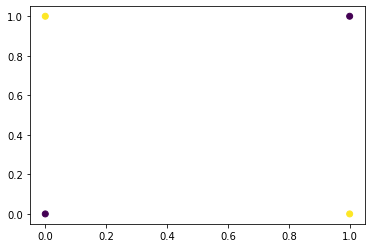

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], c = target)

In [ ]:
model1 = Sequential()
model1.add_layer(LinearLayer(2,2))
model1.add_layer(Sigmoid())
model1.add_layer(LinearLayer(2,1))
model1.add_layer(Sigmoid())
model1.set_loss(CrossEntropyLoss())

In [ ]:
model1.fit(data,target,10,0.01)

[[0 0]]
[[ 0.46025122 -0.03596918]]
[[0.61307377 0.49100867]]
[[-0.49105845]]


TypeError: ignored

In [ ]:
model1.plot()

In [ ]:
with open('xor_solved.pkl', 'wb') as outp:
    pickle.dump(model1, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
model2 = Sequential()
model2.add(Linear(2,2,2))
model2.add(tanh())
model2.add(Linear(2,1,2))
model2.add(sigmoid())
model2.set_error(crossEntropyLoss())
model2.fit(samples,targets,10,0.01)

In [ ]:
model2.plot()

In [ ]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [ ]:
y_train =  get_one_hot(y_train.astype(int), 10)
y_test = get_one_hot(y_test.astype(int), 10)

In [ ]:

model_1 = Sequential()
model_1.add(LinearLayer(28*28,64))
model_1.add(Tanh())
model_1.add(LinearLayer(64,10))
model_1.add(Sigmoid())
model_1.set_error(CrossEntropyLoss())
model_1.fit(X_train,y_train,10,0.001)

In [ ]:
predicted = model_1.predict(X_test)

In [ ]:
print(f'Accuracy of model 1 : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_1.plot()

In [ ]:
model_2 = Sequential()
model_2.add(LinearLayer(28*28,100,10))
model_2.add(tanh())
model_2.add(Linear(100,10,10))
model_2.add(sigmoid())
model_2.set_error(crossEntropyLoss())
model_2.fit(X_train,y_train,10,0.01)

In [ ]:
predicted = model_2.predict(X_test)
print(f'Accuracy of model 2 : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_2.plot()

In [ ]:
model_3 = Sequential()
model_3.add(Linear(28*28,100,1))
model_3.add(tanh())
model_3.add(Linear(100,10,1))
model_3.add(sigmoid())
model_3.set_error(crossEntropyLoss())
model_3.fit(X_train,y_train,10,1)

In [ ]:
predicted = model_3.predict(X_test)
print(f'Accuracy of model 3 : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_3.plot()

In [ ]:
model_4 = Sequential()
model_4.add(Linear(28*28,100,1))
model_4.add(tanh())
model_4.add(Linear(100,10,1))
model_4.add(sigmoid())
model_4.set_error(crossEntropyLoss())
model_4.fit(X_train,y_train,10,0.001)

In [ ]:
predicted = model_4.predict(X_test)
print(f'Accuracy of model 4 : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_4.plot()